# Praca domowa 3

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Exploration

In [2]:
rain_df = pd.read_csv("https://raw.githubusercontent.com/gekas145/2021L-WUM/main/Prace_domowe/Praca_domowa3/australia.csv")
rain_df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
3,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
4,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


In [3]:
rain_df.shape

(56420, 18)

In [52]:
rain_df.duplicated(keep='first').sum()
# niema duplikatów

0

In [19]:
rain_df.info()
# zdecydowana większość cech jest ciągła

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56420 entries, 0 to 56419
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        56420 non-null  float64
 1   MaxTemp        56420 non-null  float64
 2   Rainfall       56420 non-null  float64
 3   Evaporation    56420 non-null  float64
 4   Sunshine       56420 non-null  float64
 5   WindGustSpeed  56420 non-null  float64
 6   WindSpeed9am   56420 non-null  float64
 7   WindSpeed3pm   56420 non-null  float64
 8   Humidity9am    56420 non-null  float64
 9   Humidity3pm    56420 non-null  float64
 10  Pressure9am    56420 non-null  float64
 11  Pressure3pm    56420 non-null  float64
 12  Cloud9am       56420 non-null  float64
 13  Cloud3pm       56420 non-null  float64
 14  Temp9am        56420 non-null  float64
 15  Temp3pm        56420 non-null  float64
 16  RainToday      56420 non-null  int64  
 17  RainTomorrow   56420 non-null  int64  
dtypes: flo

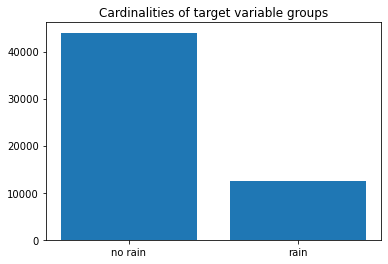

In [3]:
groups_cardinality_df = rain_df.groupby("RainTomorrow").size().reset_index(name="cardinality")

fig, axes = plt.subplots(1, 1)
axes.bar(groups_cardinality_df["RainTomorrow"], height=groups_cardinality_df["cardinality"])
axes.set_xticks([0, 1])
axes.set_xticklabels(["no rain", "rain"])
axes.set_title("Cardinalities of target variable groups")
plt.show()
# target nie jest zrównoważony

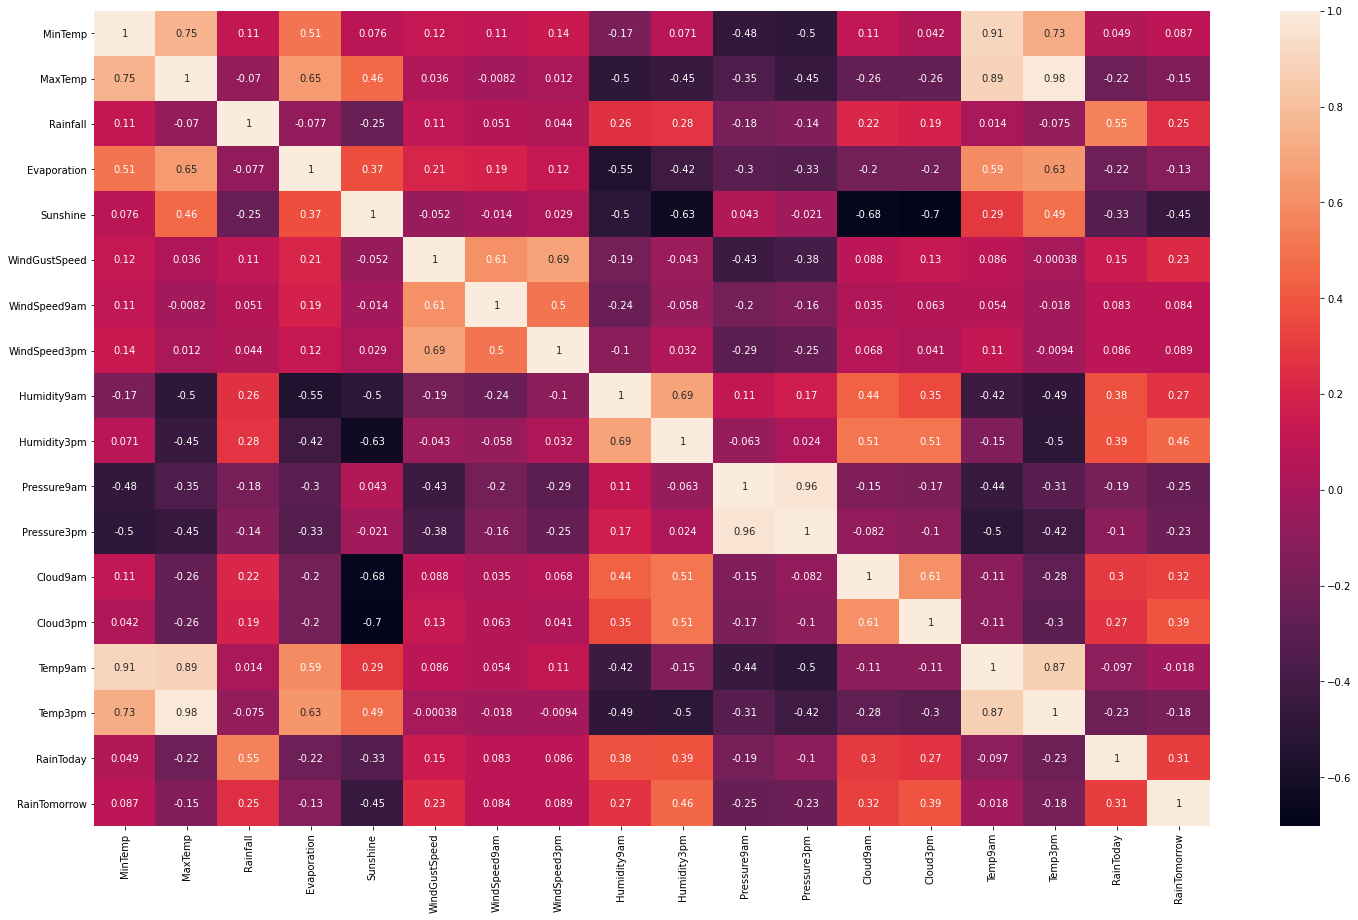

In [22]:
plt.figure(figsize=(25,15))
corr = rain_df.corr()
sns.heatmap(corr, annot=True)
plt.show()

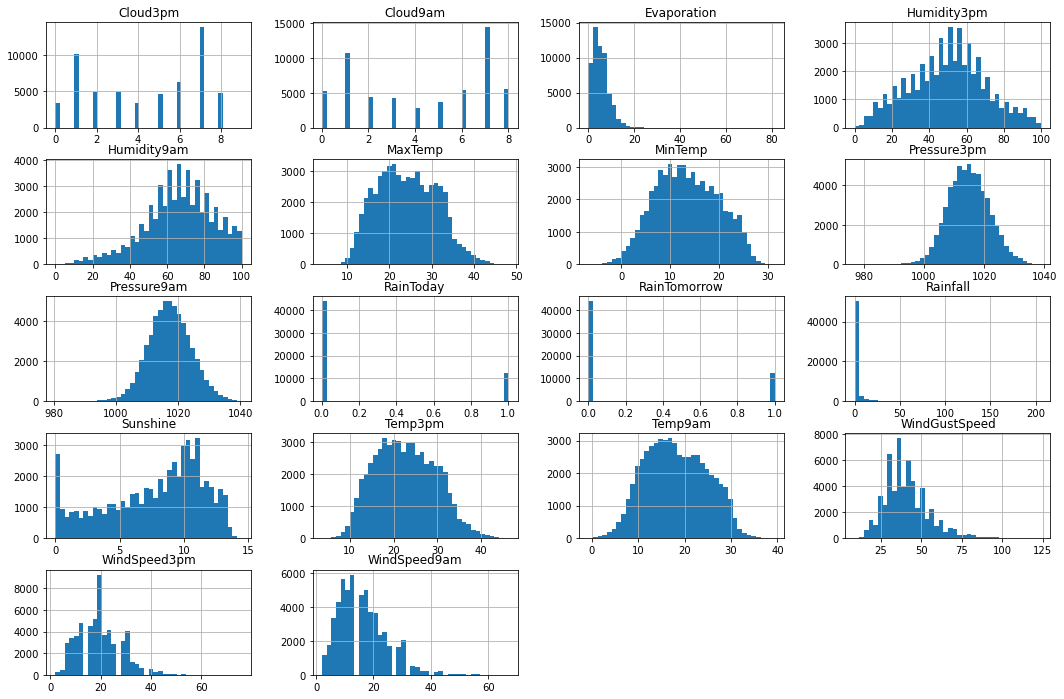

In [23]:
rain_df.hist(figsize=(18, 12), bins=40)
plt.show()

## Preprocessing

## Modelling and scoring

In [3]:
# ze skorelowanych par odrzucamy po jednej kolumnie
X_train, X_test, y_train, y_test = train_test_split(rain_df.drop(["RainTomorrow", "MinTemp", "MaxTemp", "Temp9am", "Sunshine"], 
                                                                 axis=1), 
                                                    rain_df["RainTomorrow"], 
                                                    test_size=0.3, shuffle=True, random_state=42)

In [46]:
def get_stats(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    
    print(f"F1 score: {f1_score(y_test, y_pred):.6f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred):.6f}")
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f"Precision: {tp/(tp + fp):.2f}")
    print(f"Recall: {tp/(tp + fn):.2f}")
    print(f"Specificity: {tn/(tn + fp):.2f}")

Wykorzystane miary to:
- F1-score
- Matthews Correlation Coefficient(MCC)
- 

### Logistic regression

In [51]:
lg = LogisticRegression(max_iter = 400, random_state=0)
lg.fit(X_train, y_train)
get_stats(lg, X_test, y_test)

F1 score: 0.611146
MCC: 0.539420
Precision: 0.75
Recall: 0.51
Specificity: 0.95


C:\Users\yevhe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random forest

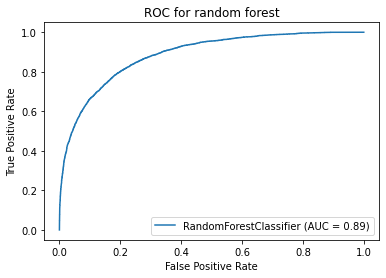

In [16]:
rfc = RandomForestClassifier(max_depth=16, n_estimators=400, random_state=0)
rfc.fit(X_train, y_train)

metrics.plot_roc_curve(rfc, X_test, y_test)
plt.title("ROC for random forest")
plt.show()

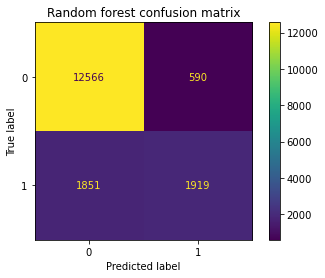

In [44]:
plot_confusion_matrix(rfc, X_test, y_test)
plt.title("Random forest confusion matrix")
plt.show()

In [47]:
get_stats(rfc, X_test, y_test)

F1 score: 0.611244
MCC: 0.543530
Precision: 0.76
Recall: 0.51
Specificity: 0.96


### Gradient boosting

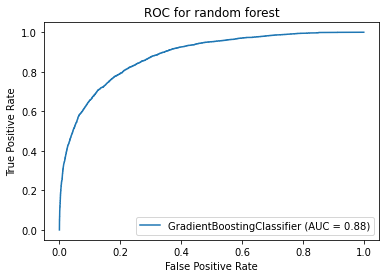

In [7]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0)
gbc.fit(X_train, y_train)
metrics.plot_roc_curve(gbc, X_test, y_test)
plt.title("ROC for gradient boosting")
plt.show()

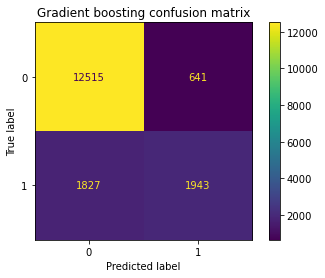

In [43]:
plot_confusion_matrix(gbc, X_test, y_test)
plt.title("Gradient boosting confusion matrix")
plt.show()

In [48]:
get_stats(gbc, X_test, y_test)

F1 score: 0.611583
MCC: 0.539863
Precision: 0.75
Recall: 0.52
Specificity: 0.95


## Conclusion

@ToDo